In [1]:
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF
import os
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings
import warnings
warnings.filterwarnings("ignore")


# Coding Discussion 5
 Chau Nguyen


### General cleaning

In [2]:
# Read in the turnout data
turnout_data = pd.read_csv("../turnout.csv")

In [3]:
# Print summary statistics
np.round(turnout_data.describe(), 2).T[['mean', 'std', 'min', 'max']]

,mean,std,min,max
id,1000.50,577.49,1.0,2000.00
age,45.30,17.52,17.0,95.00
educate,12.07,3.37,0.0,19.00
income,3.89,2.83,0.0,14.92
vote,0.75,0.44,0.0,1.00
white,0.85,0.35,0.0,1.00


There is one 17 year old voter in the dataset but let's leave it in because the data is from a pre-election & post-election interview.

#### Split the dataset up

In [4]:
# Split data into train/ test:
train = turnout_data.sample(frac=.8).reset_index(drop=True)

test = turnout_data.drop(train.index).reset_index(drop=True)

# Print off the split count
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

Training Data: 1600 
Test Data: 400


In [5]:
# Look at the head of the data
train.head()

,id,age,educate,income,vote,white
0,1170,53,14.0,11.2351,1,1
1,1462,24,16.0,2.9170,1,1
2,767,43,10.0,4.4312,1,1
3,1005,46,12.0,3.4183,1,1
4,1784,64,14.0,3.3458,1,1


In [6]:
# Drop the id column in both datasets:
train = train.drop(columns=["id"])
test = test.drop(columns=["id"])

## Part 1: Build Naive Bayesian Classifier with Binary Predictor

In [7]:
# Number of observations in the training data
N = train.shape[0]

# Subset the data by whether someone voted or not
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

train.query("vote ==1").shape[0]/train.shape[0]

# Calculate the probability:
pr_vote_1 = vote1.shape[0]/N
pr_vote_0 = vote0.shape[0]/N

#### $Pr(\text{Vote})$ is the prior probability of someone voting.

In [8]:
# Print the probabilities
print(
f"""
Pr(vote = 1): {pr_vote_1}
Pr(vote = 0): {pr_vote_0}
""")


Pr(vote = 1): 0.745
Pr(vote = 0): 0.255



#### Observation: The probability that someone in the training dataset vote is around 75%.

In the data, "white" is a binary variable. We subset the training data into 2 separate bins - voter and non-voter, and find the percentage of white in each bin. 

#### $Pr(\text{White|Vote})$
This gives us the $Pr(\text{White|Vote})$, which is the conditional probability of "White" given "Vote".

In [9]:
#Given vote == 1
w1_vote1 = vote1.query("white == 1").shape[0]/vote1.shape[0]
w0_vote1 = vote1.query("white == 0").shape[0]/vote1.shape[0]
#Given vote == 0
w1_vote0 = vote0.query("white == 1").shape[0]/vote0.shape[0]
w0_vote0 = vote0.query("white == 0").shape[0]/vote0.shape[0]

In [10]:
print(
f"""
Pr(white = 1| vote = 1): {w1_vote1}
Pr(white = 0| vote = 1): {w0_vote1}
Pr(white = 1| vote = 0): {w1_vote0}
Pr(white = 0| vote = 0): {w0_vote0}
""")


Pr(white = 1| vote = 1): 0.87751677852349
Pr(white = 0| vote = 1): 0.12248322147651007
Pr(white = 1| vote = 0): 0.7794117647058824
Pr(white = 0| vote = 0): 0.22058823529411764



##### Make a prediction
We want to predict whether someone will vote or not, given their race. This means we want to find

$Pr(\text{Vote|White})$ - the posterior probability, or the updated probability of Vote given White.

In [11]:
# If white == 1
prob_w_vote1 = w1_vote1 * pr_vote_1
prob_w_vote0 = w1_vote0 * pr_vote_0
print(f"""
Pr(vote = 1) = {prob_w_vote1}
Pr(vote = 0) = {prob_w_vote0}
""")


Pr(vote = 1) = 0.65375
Pr(vote = 0) = 0.19875



0.656 is larger than 0.196, so we predict that **a white person would vote.**

In [12]:
# If white == 0 
prob_nw_vote1 = w0_vote1 * pr_vote_1
prob_nw_vote0 = w0_vote0 * pr_vote_0

print(f"""
Pr(vote = 1) = {prob_nw_vote1}
Pr(vote = 0) = {prob_nw_vote0}
""")


Pr(vote = 1) = 0.09125
Pr(vote = 0) = 0.05625



0.0906 is larger than 0.0513, so we predict that **a non-white person would also vote.**

If we only use $Pr(\text{Vote|White})$ to make a prediction, we will always predict that a person would vote and be correct 75% of the time (because 75% of the training dataset are voters).

I now build a funciton that calculates the class probability $Pr(\text{Vote})$ and conditional probabilities $Pr(\text{White|Vote})$ similar to the calculations above.

In [13]:
# Define function calc_probs

def calc_probs(data, outcome_var=""):
    '''
    Function calculates the class and conditional probabilities in
    the binary data.

    Args: 1) dataset
          2) outcome_var: the outcome we want to predict
    Returns: A dictionary containing 1) The class probabilities of the outcome vars 
            and 2) The conditional probabilities of each variable given the class
    '''
    # Generate empty dictionary containers.
    class_probs = {};cond_probs = {}
    # Locate all variables that are not the outcome.
    vars = [v for v in data.columns if v != outcome_var]
    # iterate through the class outcomes
    for y, d in data.groupby(outcome_var):
        # calculate the class probabilities
        class_probs.update({y: d.shape[0]/data.shape[0]})
        for v in vars:
            # calculate the conditional probabilities for each variable given the class.
            pr = d[v].sum()/d.shape[0]
            cond_probs[(v,1,y)] = pr
            cond_probs[(v,0,y)] = 1 - pr
    return class_probs, cond_probs

In [14]:
# Run it, saving values for class_probs and cond_probs to be used later

class_probs, cond_probs = calc_probs(train[["white","vote"]], outcome_var = "vote")
# Print
print("class probabilities",end="\n\n")
pp.pprint(class_probs)
print("\n")
print("conditional probabilities",end="\n\n")
pp.pprint(cond_probs)

class probabilities

{0: 0.255, 1: 0.745}


conditional probabilities

{('white', 0, 0): 0.22058823529411764,
 ('white', 0, 1): 0.12248322147651003,
 ('white', 1, 0): 0.7794117647058824,
 ('white', 1, 1): 0.87751677852349}


In [15]:
# Build predict_binary function
def predict_binary(data,class_probs,cond_probs):
    '''
    This function calculates the conditional probability for membership into each class.
    Then returns both probabilities, together with the most likely class.
    '''
    store_preds = []
    for i,row in data.iterrows():
        pr_1 = 1; pr_0 = 1
        for j in range(0,len(row.index)):
            #print(row.index[j])
            pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
            pr_1 *= cond_probs[(row.index[j],row.values[j],1)]
        pr_0 *= class_probs[0]
        pr_1 *= class_probs[1]
        store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])

    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

In [16]:
# Run the predict_binary function on the white column of the training dataset
preds_train_binary = predict_binary(train[["white"]], class_probs, cond_probs)
# Check the prediction for voter
preds_train_binary.pred.unique()

array([1])

There is only one value pred==1 in in preds_train_binary, meaning that the predict_binary function predicts that people in the training dataset would vote 100% of the time.

### Binary Predictor: Test for accuracy 

In [17]:
# Examine the predictive accuracy of the training data
accuracy_train_binary = sum(train.vote == preds_train_binary.pred)/train.shape[0]
accuracy_train_binary

0.745

In [18]:
preds_test_binary = predict_binary(test[["white"]], class_probs, cond_probs)
accuracy_test_binary = sum(test.vote == preds_test_binary.pred)/test.shape[0]
accuracy_test_binary

0.7

**Observation:** On the training dataset, the predictive accuracy is about 75%, which is what we expected because 75% of the dataset is voter, and the simple binary predictor predicted that 100% of the training dataset would vote. 

## Part 2: Build Naive Bayesian Classifier with Continuous Predictors
In the data, age, educate, and income are all continuous predictors. We need to  calculate the conditional mean and standard deviation for each value of the outcome, then calculate the predictions from there for any one of our continuous variables.



In [19]:
# Collect the mean and SD of each conditional distribution
dist_locs = \
{("age", 1): {"mean":vote1.age.mean(),'sd':vote1.age.std()},
("age", 0): {"mean":vote0.age.mean(),'sd':vote0.age.std()},
("income", 1): {"mean":vote1.income.mean(),'sd':vote1.income.std()},
("income", 0): {"mean":vote0.income.mean(),'sd':vote0.income.std()},
("educate", 1): {"mean":vote1.educate.mean(),'sd':vote1.educate.std()},
("educate", 0): {"mean":vote0.educate.mean(),'sd':vote0.educate.std()}
}

# Print
pp.pprint(dist_locs)

{('age', 0): {'mean': 43.181372549019606, 'sd': 19.145798958714156},
 ('age', 1): {'mean': 46.23322147651007, 'sd': 17.01363024549987},
 ('educate', 0): {'mean': 10.595588235294118, 'sd': 3.2706618054696603},
 ('educate', 1): {'mean': 12.568372483221477, 'sd': 3.29314705108937},
 ('income', 0): {'mean': 2.7510441176470586, 'sd': 2.2720795201882082},
 ('income', 1): {'mean': 4.152318624161074, 'sd': 2.838093473987771}}


Now, let's try to predict whether an 18 year old whose education is 12 and income is 4 would vote or not.

In [20]:
# Probability that the hypothetical person would vote:

pr_non_voter = (st.norm(dist_locs[("age",0)]['mean'],
                       dist_locs[("age",0)]['sd']).pdf(18) *
                st.norm(dist_locs[("educate",0)]['mean'],
                       dist_locs[("educate"),0]['sd']).pdf(12) *
                st.norm(dist_locs[("income",0)]['mean'],
                       dist_locs[("income"),0]['sd']).pdf(4) *
                pr_vote_0
               )

# Probability that the hypothetical person not would vote:
pr_voter = (st.norm(dist_locs[("age",1)]['mean'],
                       dist_locs[("age",1)]['sd']).pdf(18) *
                st.norm(dist_locs[("educate",1)]['mean'],
                       dist_locs[("educate"),1]['sd']).pdf(12) *
                st.norm(dist_locs[("income",1)]['mean'],
                       dist_locs[("income"),1]['sd']).pdf(4) *
                pr_vote_1
               )

In [21]:
print("Probability this person would vote: " + str(round(pr_voter*100,8)))
print("Probability this person would not vote: " + str(round(pr_non_voter*100,8)))

Probability this person would vote: 0.00738559
Probability this person would not vote: 0.00375708


0.00726 > 0.00399, so we predict that this hypothetical person would vote.

Now, we build a function to calculate the conditional probability for continuous predictors.

In [22]:
# Definite function predict_cont to calculate the conditional probabilities of continuous predictor and get binary prediction
def predict_cont(data,dist_locs):
    '''
    This function use the probability density function for normal distribution to convert continuous values into probabibilities
    Args: 1) dataset
        2) dist_locs: dictionary of each conditional distribution for the continuous variables, calculated above
    Returns: Probability of vote == 0, Probability of vote == 1, and prediction whether the person would vote or not
    '''
    store_preds = []
    for i, row in data.iterrows():

        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1

        for j in range(0,len(row)):
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'],
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])

        # Multiplies by the probability of finding each class
        pr_0 *= pr_vote_0
        pr_1 *= pr_vote_1

        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1

        store_preds.append([pr_0.round(6),pr_1.round(6),class_pred])

    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

In [23]:
# This is a 1-row dataset of the hypothetical 18-year-old voter above
pd.DataFrame(np.array([[18,12,4]]), columns = ["age","educate","income"])

,age,educate,income
0,18,12,4


In [24]:
# Run predict_cont on the hypothetical dataset
predict_cont(pd.DataFrame(np.array([[18,12,4]]), columns = ["age","educate","income"]),dist_locs)

,pr_0,pr_1,pred
0,0.000038,0.000074,1


**Observation:** The function predict_cont() also predicts that the hypothetical 18 year-old would vote, and the probabilities of vote & no-vote are the same as if we calculate it by hand.

### Continuous Predictor: Test for accuracy

In [25]:
# Run pred_cont() on the whole training dataset
preds_train_cont = predict_cont(train[["age","educate","income"]], dist_locs)

In [26]:
# Examine the predictive accuracy of the training data
accuracy_train_cont = sum(train.vote == preds_train_cont.pred)/train.shape[0]

accuracy_train_cont

0.743125

Accuracy is also around 75% with the continuous predictors.

## Part 3: Build Naive Bayesian Classifier with Binary and Continuous Predictors

Now, we put together what we learned in part 1 and part 2 into one function.

In [27]:
# Define function predict
def predict(data,class_probs,cond_probs,dist_locs):
    '''
    Args: 1) dataset
        2) class_probs: probability that someone vote or not, defined above
        3) cond_probs: probability that someone vote or not depending on a binary predictor, which is "white" in this case, also defined above
        4) dist_locs: dictionary of each conditional distribution for the continuous variables
    
    Returns: Probability of vote == 0, Probability of vote == 1, and prediction whether the person would vote or not
    '''
    store_preds = []
    for i, row in data.iterrows():

        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1

        for j in range(0,len(row)):

                # First, filter out the "vote" column
                if row.index[j] != "vote":

                    # If the column is "white" (which is a binary dummy variable)
                    # Then multiply the probability of each class (vote0 and vote1) by the conditional probability
                   
                    if row.index[j] == "white":
                        pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
                        pr_1 *= cond_probs[(row.index[j],row.values[j],1)]

                    # If the column is not "white"
                    # Then use mean and sd to get the prediction for each class
                    if row.index[j] != "white":
                        pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                                dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                        pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'],
                                dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])

        # Multiplies by the probability of finding each class
        # This is the same formula to calculate pr_vote_0 and pr_vote_1 above
        pr_0 *= data.query("vote == 0").shape[0]/data.shape[0]
        pr_1 *= data.query("vote == 1").shape[0]/data.shape[0]

        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1

        store_preds.append([pr_0.round(6),pr_1.round(6),class_pred])

    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])


In [28]:
# Run it on the training data
preds_train = predict(train,class_probs,cond_probs,dist_locs)

In [29]:
# Check the values in the pred array to see if we got vote AND non-vote predictions
preds_train.pred.unique()

array([1, 0])

In [30]:
accuracy_train = sum(train.vote == preds_train.pred)/train.shape[0]
accuracy_train

0.73875

**Observation:** The combined predictor function is also accurate around 75% of the time. 

This is actually not great, because if we predicted that a person would always vote, we would also get around 75% accuracy from this data set.

In [31]:
# Run it on the test data
preds_test = predict(test, class_probs, cond_probs, dist_locs)

In [32]:
# Check the values in the pred array to see if we got vote AND non-vote predictions
preds_test.pred.unique()

array([1, 0])

In [33]:
accuracy_test = sum(test.vote == preds_test.pred)/test.shape[0]
accuracy_test

0.7175

In [34]:
sum(preds_test.pred)

327

## Part 4: sklearn implementation and performance

In [35]:
# Organize data to plug into sklearn API
train_vote = train["vote"]
train_predvar = train[["white","age","educate","income"]]

test_vote = test["vote"]
test_predvar = test[["white","age","educate","income"]]

In [36]:
from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m # Metrics to determine the classification 

In [37]:
#Predict from Part 3 above
vote_pred = preds_test.pred

In [38]:
#Out-of-sample perfomance
m.accuracy_score(test_vote,vote_pred)

0.7175

Our predict() model has an accuracy of 71.75%. 

Next, I will generate model predictors where 100%, 75%, 50%, 25%, and 0% of the 400 rows in the sample would vote, and test the accuracy of those predictors against the test data.

In [39]:
# Generate predictor where 100% of people votes
all_votes_pred =  pd.Series([1]).repeat(400)

In [40]:
# Generate np array of 400 random samples ranging from 0 to 1, where 25% are 0's and 75% are 1's
quarter_no_vote_pred = np.random.choice([0, 1], size=400, p =[0.25,0.75])
# Turn that into pd series
quarter_no_vote_pred = pd.Series(quarter_no_vote_pred)
quarter_no_vote_pred.describe()


count    400.000000
mean       0.790000
std        0.407818
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64

In [41]:
# Generate np array of 400 random samples ranging from 0 to 1, where 75% are 0's and 25% are 1's
quarter_vote_pred = np.random.choice([0, 1], size=400, p =[0.75,0.25])
# Turn that into pd series
quarter_vote_pred = pd.Series(quarter_vote_pred)
quarter_vote_pred.describe()

count    400.000000
mean       0.240000
std        0.427618
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
dtype: float64

In [42]:
# Generate np array of 400 random samples ranging from 0 to 1, where half is 0 and half is 1
half_vote_pred = np.random.choice([0, 1], size=400, p =[0.5,0.5])
# Turn that into pd series
half_vote_pred = pd.Series(half_vote_pred)
half_vote_pred.describe()

count    400.000000
mean       0.505000
std        0.500601
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64

In [43]:
# Generate predictor where everyone votes
zero_votes_pred =  pd.Series([0]).repeat(400)
zero_votes_pred.describe()

count    400.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [44]:
print("If we guess that 100% of the sample is voter, the accuracy score is:",  m.accuracy_score(test_vote, all_votes_pred))
print("If we generate a model where 75% are voters, the accuracy score for that model is:", m.accuracy_score(test_vote, quarter_no_vote_pred))
print("And if I guessed that 50% of the test data are voters, the accuracy of this model would be:", m.accuracy_score(test_vote, half_vote_pred))
print("The accuracy score for the model where 25% are voters is:", m.accuracy_score(test_vote, quarter_vote_pred))
print("Finally, accuracy score for the model where 0% are voters is:", m.accuracy_score(test_vote, zero_votes_pred))

If we guess that 100% of the sample is voter, the accuracy score is: 0.7
If we generate a model where 75% are voters, the accuracy score for that model is: 0.59
And if I guessed that 50% of the test data are voters, the accuracy of this model would be: 0.495
The accuracy score for the model where 25% are voters is: 0.39
Finally, accuracy score for the model where 0% are voters is: 0.3


Compare to the above, the 71.75% accuracy score we get from our Bayesian model is not bad, but it's not great either. We could have guessed that 100% of the sample are voters and still be accurate 70% of the time.

#### ROC Curve

Next, we consider an alternative performance metrics - the area under the ROC curve.

In [45]:
#Calculate the area under the ROC curve
roc_auc = m.roc_auc_score(test_vote, vote_pred)
roc_auc

0.6077380952380953

The area under the ROC curve using our model is about 0.61.

In [46]:
print("On the other hand, if we were to predict 100% people vote, the area under the ROC curve is", 100*m.roc_auc_score(test_vote, all_votes_pred).round(2))
print("If we use a random model to predict that 75% of the sample are voters, the AUC under the ROC curve is", 100*m.roc_auc_score(test_vote, quarter_no_vote_pred).round(2))
print("If we predict that 50% are voters, the area under the ROC is", 100*m.roc_auc_score(test_vote, half_vote_pred).round(2)) 
print("If we predict that 25% are voters, the area under the ROC is", 100*m.roc_auc_score(test_vote, quarter_vote_pred).round(2)) 
print("And finally, if we predict that 0% are voters, the area under the ROC is", 100*m.roc_auc_score(test_vote, zero_votes_pred).round(2)) 

On the other hand, if we were to predict 100% people vote, the area under the ROC curve is 50.0
If we use a random model to predict that 75% of the sample are voters, the AUC under the ROC curve is 47.0
If we predict that 50% are voters, the area under the ROC is 49.0
If we predict that 25% are voters, the area under the ROC is 49.0
And finally, if we predict that 0% are voters, the area under the ROC is 50.0


#### Plot the ROC curve
Finally, we will plot the ROC curve of our model, plus the trial models above.

In [47]:
# Get the probabilities from the prediction based on the test dataset
probs = preds_test[["pr_0","pr_1"]]

# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_vote, probs["pr_1"])


In [48]:
# Generate the FPR and TPR for the all_votes_pred data
fpr_all_votes, tpr_all_votes, thresolds_all_votes = m.roc_curve(test_vote, all_votes_pred)

# Generate the FPR and TPR for the quarter_no_vote_pred data
fpr_quarter_no_vote, tpr_quarter_no_vote, thresolds_quarter_no_vote = m.roc_curve(test_vote, quarter_no_vote_pred)

# Generate the FPR and TPR for the quarter_vote_pred data
fpr_quarter_vote, tpr_quarter_vote, thresolds_quarter_vote = m.roc_curve(test_vote, quarter_vote_pred)

# Generate the FPR and TPR for the zero_votes_pred data
fpr_zero_vote, tpr_zero_vote, thresolds_zero_vote = m.roc_curve(test_vote, zero_votes_pred)

# Generate the FPR and TPR for the half_vote_pred data
fpr_half_vote, tpr_half_vote, thresolds_half_vote = m.roc_curve(test_vote, half_vote_pred)


Text(0.5, 1.0, 'ROC Curve')

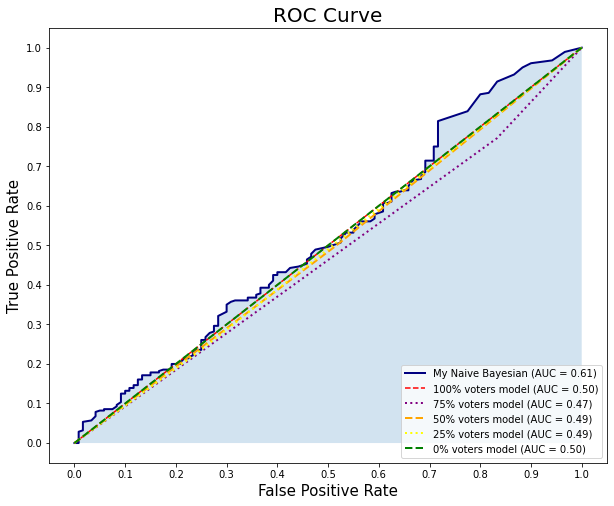

In [55]:
#Plot the ROC Curve
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label="My Naive Bayesian (AUC = {0:0.2f})".format(roc_auc),
    color='navy', linewidth=2)
plt.fill_between(fpr, tpr,alpha =0.2)
plt.plot(fpr_all_votes, tpr_all_votes, label="100% voters model (AUC = {0:0.2f})".format(m.roc_auc_score(test_vote, all_votes_pred)), color='red', linestyle='--')
plt.plot(fpr_quarter_no_vote, tpr_quarter_no_vote, label="75% voters model (AUC = {0:0.2f})".format(m.roc_auc_score(test_vote, quarter_no_vote_pred)), color = "purple", linestyle=":",linewidth=2)
plt.plot(fpr_half_vote, tpr_half_vote, label="50% voters model (AUC = {0:0.2f})".format(m.roc_auc_score(test_vote, half_vote_pred)), color = "orange", linestyle="--",linewidth=2)

plt.plot(fpr_quarter_vote, tpr_quarter_vote, label="25% voters model (AUC = {0:0.2f})".format(m.roc_auc_score(test_vote, quarter_vote_pred)), color = "yellow", linestyle=":",linewidth=2)
plt.plot(fpr_zero_vote, tpr_zero_vote, label="0% voters model (AUC = {0:0.2f})".format(m.roc_auc_score(test_vote, zero_votes_pred)), color = "green", linestyle="--",linewidth=2)

plt.legend(loc="lower right")
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC Curve",fontsize=20)

The plot shows how my Naive Bayesian model does compared to a model where I guess that everyone is a voter 100% of the time. The area under the ROC curve for my model is 0.61, is better than the area under the curve where I guess that all are voters. Interestingly, whether we guess that 100%, 75%, 50%, 25% or 0% of the data are voters, the AUC does not change much - the area under the ROC curve still around 50%, which is about as good as a random guess. 

This tells us that,  our Naive Bayesian model does better than random (and that it would be quite difficult for a model to do worse than random when predicting a binary outcome).